In [44]:
import numpy as np
from pickle import dump, load
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from os import listdir
import lightkurve as lk
import pickle
import pandas as pd
from collections import Counter

def build_model(X,lstm_layers,cells,output_size):
    model = Sequential()
    model.add(Dense(units=cells,input_shape=(X.shape[1], X.shape[2])))
    for i in range(lstm_layers - 1):
        model.add(LSTM(cells,return_sequences=True,dropout=0.1,recurrent_dropout=0.1))

    model.add(LSTM(cells,return_sequences=False,dropout=0.1,recurrent_dropout=0.1))
    # Dropout for regularization
    #model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(output_size, activation='tanh'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

# generate a sequence of characters with a language model
def generate_data(data_path, data_amount, bins=1000):
    if data_amount == 'auto':
        data_amount = len(listdir(data_path))
        print("There are {0} lightcurves present in the data_path".format(data_amount))
    list_files = listdir(data_path)[0:data_amount]
    # generate lightcurve data
    X = np.zeros((0,bins,2))
    rows = []
    for file in list_files:
        with open(data_path + '/' + file, 'rb') as rfile:
            lc = pickle.load(rfile)
        if len(lc.flux)< bins:
            continue
        lc.quality = np.zeros(len(lc.flux),dtype='int')
        lc = lc.remove_outliers(sigma=20).remove_nans()
        flux = np.reshape(np.array([lc.time[:bins]]),(bins,1))
        flux_norm = (flux - np.min(flux))/(np.max(flux)-np.min(flux))
        time = np.reshape(np.array([lc.flux[:bins]]),(bins,1))
        time_norm = (time - 0)/(3000-0)
        X_curve = np.array([np.concatenate((flux,time),axis=1)])

        X = np.concatenate((X,X_curve),axis=0)
        row = int(file.split('-')[0])
        rows.append(row)
    print('Generating lightcurve data complete')
    
    what_rows = []
    [what_rows.append(x) for x in rows if x not in what_rows]
    count_rows = Counter(rows)
    print('Objects identified')
    y = []
    ya = pd.read_csv('final_catalogue.csv', sep=',', usecols=['Tmag'],header=0,squeeze=True).to_numpy()
    for r in what_rows:
        y_point = [ya[r]]
        y_list = []
        for x in range(0,count_rows[r]):
            y_list += y_point
        y += y_list
    print('Magnitudes created')
    
    y = np.array(y)
    y = (y-10)/(18-10)
    return X,y


In [45]:
X,y = generate_data(data_path = 'C:/Users/811261/Documents/Research/Lightcurves/sector_lightcurves',data_amount='auto',bins=700)

firstRun = True
if firstRun is False:
    #model = load_model(str('bot.h5'))
    print("Model loaded")
else:
    model = build_model(X,lstm_layers=1,cells=100,output_size=1)
model.summary()

history = model.fit(X, y, batch_size=50, epochs=20, verbose=1, callbacks = [EarlyStopping(monitor='val_loss', patience=2)], validation_split=0.1)
print((model.predict(np.array([X[0]]), verbose=0) * 8) + 10)
#model.save(str('bot.h5'))


There are 140 lightcurves present in the data_path
Generating lightcurve data complete
Objects identified
Magnitudes created
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\811261\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 3722, in <genexpr>
    for ta, input_ in zip(input_ta, flatted_inputs))  File "C:\Users\811261\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\

In [ ]:
in_text = input()
n_chars = 100
diversity = 0.5
seq_length = 100

generate_seq(model, mapping, in_text, n_chars, diversity, seq_length=seq_length)

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [27]:
data_amount = 'auto'
data_path = 'C:/Users/811261/Documents/Research/Lightcurves/sector_lightcurves'
bins=1000
if data_amount == 'auto':
    data_amount = len(listdir(data_path))
    print("There are {0} lightcurves present in the data_path".format(data_amount))
list_files = listdir(data_path)[0:data_amount]
# generate lightcurve data
X = np.zeros((0,1000,2))
rows = []
for file in list_files:
    with open(data_path + '/' + file, 'rb') as rfile:
        lc = pickle.load(rfile)
    if len(lc.flux)< bins:
        continue
    lc.quality = np.zeros(len(lc.flux),dtype='int')
    lc = lc.remove_outliers(sigma=20).remove_nans()
    flux = np.reshape(np.array([lc.time[:bins]]),(bins,1))
    time = np.reshape(np.array([lc.flux[:bins]]),(bins,1))
    X_curve = np.array([np.concatenate((flux,time),axis=1)])
    
    X = np.concatenate((X,X_curve),axis=0)
    row = int(file.split('-')[0])
    rows.append(row)
print('Generating lightcurve data complete')

There are 140 lightcurves present in the data_path
Generating lightcurve data complete


In [57]:
l = [17]
for num in range(0,126):
    l.append(float((model.predict(np.array([X[num]]), verbose=0) * 8) + 10))
print(l)

[17, 17.069316864013672, 17.101011276245117, 17.101011276245117, 17.02680778503418, 17.101011276245117, 17.100982666015625, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.069316864013672, 17.620288848876953, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.099929809570312, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.620288848876953, 17.02680778503418, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.069316864013672, 17.10093116760254, 17.02680778503418, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117, 17.101011276245117,

17.136375247024176


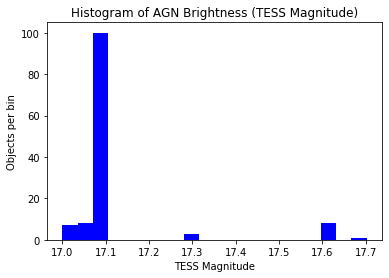

In [58]:
# Import the libraries
import matplotlib.pyplot as plt

data = l
# matplotlib histogram
plt.hist(data, color = 'blue',bins = 20)

# Add labels
plt.title('Histogram of AGN Brightness (TESS Magnitude)')
plt.xlabel('TESS Magnitude')
plt.ylabel('Objects per bin')
#plt.savefig('sect.png',dpi=1000)
print(np.mean(data))

In [56]:
float((model.predict(np.array([X[num]]), verbose=0) * 8) + 10)

17.620288848876953